In [50]:
# Import Librarys
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from itertools import combinations
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron as SklearnPerceptron, SGDClassifier
from sklearn.model_selection import GridSearchCV


import gc

In [51]:
# X is features y is prediction (This for me to remember)
# Set pathing for base and validation sets (CHANGE THESE TO YOUR PATHINGS)
pa_path = r"C:\Users\andre\OneDrive - University of Arkansas\Desktop\Andrew_Branch_ML\project_adult.csv"
pvi_path = r"C:\Users\andre\OneDrive - University of Arkansas\Desktop\Andrew_Branch_ML\project_validation_inputs.csv"
output_path = r"C:\Users\andre\OneDrive - University of Arkansas\Desktop\Andrew_Branch_ML"

# Read the files in
pa = pd.read_csv(pa_path)
pvi = pd.read_csv(pvi_path)


In [52]:

def preprocess_data_label(df):
    # Drop unnamed col, don't need
    df = df.drop(columns=['Unnamed: 0'], errors='ignore')

    # Handle missing values (simple drop, can be improved later)
    df = df.dropna()

    # Drop rows where any categorical column contains '?'
    df = df[~df.isin(['?']).any(axis=1)]

    # Separate categorical and numeric columns
    cat_cols = df.select_dtypes(include=['object']).columns
    income_col = df['income'].copy()

    cat_cols = cat_cols.drop('income')  # remove target col

    num_cols = df.select_dtypes(exclude=['object']).columns

    # Encode income (target) as ordinal
    income_col = income_col.map({'<=50K': 0, '>50K': 1})

    # Apply LabelEncoder to each categorical column
    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])

    # Encode numerical values
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    # Concatenate numeric, categorical, and income
    df = pd.concat([df[num_cols], df[cat_cols], income_col.rename('income')], axis=1)

    X = df.drop(columns=['income'], axis=1)
    y = df[['income']]

    # Return Features X and Prediction y
    return X.values, y.values.ravel()


def preprocess_data_validation_label(df):
    # Drop unnamed col, don't need
    df = df.drop(columns=['Unnamed: 0'], errors='ignore')

    # Handle missing values (simple drop, can be improved later)
    df = df.dropna()

    # Drop rows where any categorical column contains '?'
    df = df[~df.isin(['?']).any(axis=1)]

    # Separate categorical and numeric columns
    cat_cols = df.select_dtypes(include=['object']).columns
    num_cols = df.select_dtypes(exclude=['object']).columns

    # Apply LabelEncoder to each categorical column
    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])

    # Encode numerical values
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    # Concatenate numeric + categorical
    df = pd.concat([df[num_cols], df[cat_cols]], axis=1)

    # Only returning X Features
    return df.values

In [53]:
class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    self.best_errors_ : Int
        Lowest error found within in epoc training
    self.best_w_ : 1d-array
        Best weights that led to the lowest error
    self.best_b_ : Scalar
        Best bias that lead to the lowest error
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        # if you use libarry versions stated by book use float_, else if new use float64
        # self.b_ = np.float_(0.)
        self.b_ = np.float64(0.)

        self.errors_ = []


        # best identifiers
        self.best_errors_ = float('inf')
        self.best_w_ = self.w_.copy()
        self.best_b_ = self.b_

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)

            self.errors_.append(errors)

            if errors < self.best_errors_:
                self.best_errors_ = errors
                self.best_w_ = self.w_
                self.best_b_ = self.b_
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

In [54]:
class AdalineSGD:
    """ADAptive LInear NEuron classifier (stochastic gradient descent).

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset (epochs).
    shuffle : bool (default: True)
      Shuffles training data every epoch to prevent cycles.
    random_state : int
      Random number generator seed for reproducibility.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    losses_ : list
      Mean squared error loss function values in each epoch.

    self.best_misclassifications_  : Int
        Lowest misclassification found within in epoc training
    self.best_w_ : 1d-array
        Best weights that led to the lowest error
    self.best_b_ : Scalar
        Best bias that lead to the lowest error
    """

    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data."""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float64(0.)
        self.losses_ = []
        self.errors_ = []

        # best identifiers
        self.best_misclassifications_ = float('inf')
        self.best_w_ = self.w_.copy()
        self.best_b_ = self.b_

        for _ in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)

            losses = []
            for xi, target in zip(X, y):
                loss = self._update_weights(xi, target)
                losses.append(loss)

            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)

            # count misclassifications at the end of each epoch (haha didnt need this. asked for mse for graph)
            y_pred = self.predict(X)
            misclassifications = (y != y_pred).sum()
            if misclassifications < self.best_misclassifications_:
                self.best_misclassifications_ = misclassifications
                self.best_w_ = self.w_.copy()
                self.best_b_ = self.b_

            self.errors_.append(misclassifications)

        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing weights."""
        if not hasattr(self, "w_"):
            self.rgen = np.random.RandomState(self.random_state)
            self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
            self.b_ = np.float64(0.)

        for xi, target in zip(X, y):
            self._update_weights(xi, target)

        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        idx = self.rgen.permutation(len(y))
        return X[idx], y[idx]

    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to a single sample"""
        net_input = self.net_input(xi)
        output = self.activation(net_input)
        error = target - output
        self.w_ += self.eta * 2.0 * xi * error
        self.b_ += self.eta * 2.0 * error
        loss = (error**2).mean()
        return loss

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

In [55]:
def net_input(X, w_, b_):
    """Calculate net input"""
    return np.dot(X, w_) + b_

def activation(X):
    """Compute linear activation"""
    return X

def predict_adaline(X, w_, b_):
    """Return class label after unit step"""
    return np.where(net_input(X, w_, b_) >= 0.0, 1, 0)

def predict_perceptron(X, w_, b_):
    """Return class label after unit step"""
    return np.where(net_input(X, w_, b_) >= 0.5, 1, 0)

In [56]:
# Apply preprocessing
X_label, y_label = preprocess_data_label(pa)
X_label_validation = preprocess_data_validation_label(pvi)

# Split training and test and stratify on y to make sure the split is true and representitive (Would of done cv for algo approach but didnt ): )
X_train, X_test, y_train, y_test = train_test_split(
    X_label, y_label,
    test_size=0.2,
    random_state=42,
    stratify=y_label
)

In [57]:
# Train Perceptron and AdalineSGD to get graphs
ppn = Perceptron(eta=0.1, n_iter=50, random_state=1).fit(X_label, y_label)
ada = AdalineSGD(eta=0.00001, n_iter=50).fit(X_label, y_label)

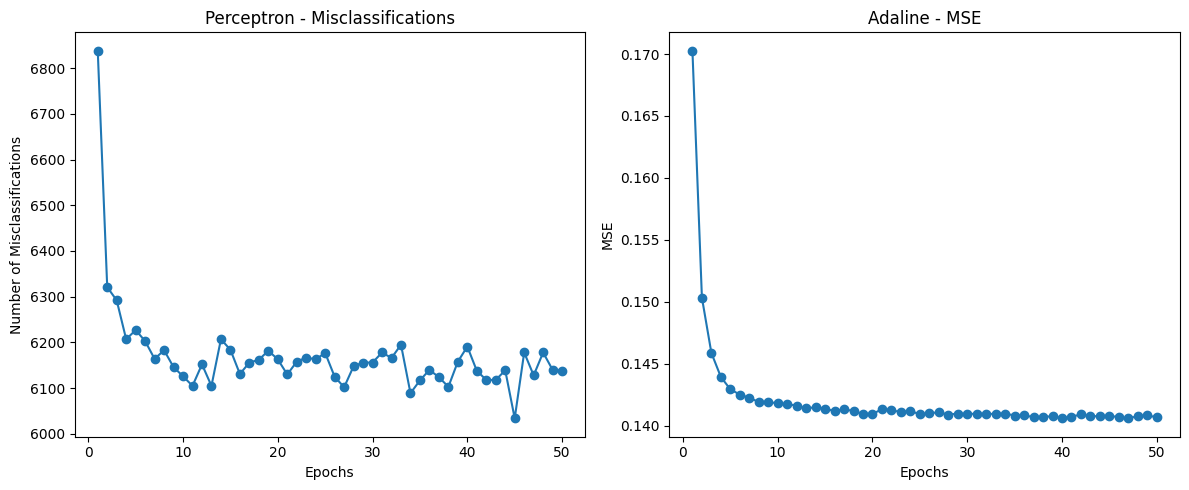

In [58]:
axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Perceptron plot
axes[0].plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Number of Misclassifications')
axes[0].set_title('Perceptron - Misclassifications')

# Adaline plot
axes[1].plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('MSE')
axes[1].set_title('Adaline - MSE')

# Adjust layout
plt.tight_layout()
plt.show()

# Graphs plotted show MIS and MSE over epochs converging (Interesting thing found that if you hotcode cat columns for perceptron it doesnt converge. After the first epoch its basically at its lowest MIS. Graph for hotcode isnt shown because one of my friends told me your suppose to label encode it which is what was done part 1)

In [59]:
# Setting up variables to pick the best model for each algo approach using a grid search
best_ppn = None
best_ppn_acc = -1
best_ppn_params = None

best_ada = None
best_ada_acc = -1
best_ada_params = None

# Grid search variables
etas = [0.1, 0.01, 0.001, .0001, .00001]
n_iters = [10, 25, 50]

# Grid search in action below (Basically just storing the paramters that gave me the best accuracy)
for eta in etas:
    for n in n_iters:
        ppn = Perceptron(eta=eta, n_iter=n, random_state=1)
        ppn.fit(X_train, y_train)

        y_pred = ppn.predict(X_test)
        misclassified = (y_test != y_pred).sum()
        accuracy = (len(y_test) - misclassified) / len(y_test)

        if accuracy > best_ppn_acc:
            best_ppn_acc = accuracy
            best_ppn = ppn
            best_ppn_params = (eta, n)
            best_ppn_mis = misclassified

# Grid search in action below (Basically just storing the paramters that gave me the best accuracy)
for eta in etas:
    for n in n_iters:
        ada = AdalineSGD(eta=eta, n_iter=n, random_state=1)
        ada.fit(X_train, y_train)

        y_pred = ada.predict(X_test)
        misclassified = (y_test != y_pred).sum()
        accuracy = (len(y_test) - misclassified) / len(y_test)

        if accuracy > best_ada_acc:
            best_ada_acc = accuracy
            best_ada = ada
            best_ada_params = (eta, n)
            best_ada_mis = misclassified

# Printed evals (Pretty similar, supprising the Adaline model got a little bit lower then perceptron)
print("=== Best Perceptron Model ===")
print(f"Params: eta={best_ppn_params[0]}, n_iter={best_ppn_params[1]}")
print(f"Misclassified={best_ppn_mis}, Accuracy={best_ppn_acc:.4f}")

print("\n=== Best AdalineSGD Model ===")
print(f"Params: eta={best_ada_params[0]}, n_iter={best_ada_params[1]}")
print(f"Misclassified={best_ada_mis}, Accuracy={best_ada_acc:.4f}")

C:\Users\andre\AppData\Local\Temp\ipykernel_73324\1120418412.py:92: RuntimeWarning: overflow encountered in double_scalars
  loss = (error**2).mean()
C:\Users\andre\AppData\Local\Temp\ipykernel_73324\1120418412.py:90: RuntimeWarning: invalid value encountered in multiply
  self.w_ += self.eta * 2.0 * xi * error


=== Best Perceptron Model ===
Params: eta=0.0001, n_iter=50
Misclassified=919, Accuracy=0.8098

=== Best AdalineSGD Model ===
Params: eta=1e-05, n_iter=10
Misclassified=947, Accuracy=0.8040


In [63]:
# Sklearn implementation (This is the ones we use for our final predictions since the accuracys are little higher then the algo approach)

# Setting up param grid to use sklearn GridSearchCV (This is a pretty cool function, didnt relize how easy it was to use)
param_grid = {
    "max_iter": [10, 25, 50, 100],
    "eta0" : [0.1, 0.01, 0.001, .0001, .00001]
}

# Running GridSearchCV with Perceptron (tol=None just has it so it does the full number of iterations instead of stopping when improvement is very little)
grid_ppn = GridSearchCV(
    estimator=SklearnPerceptron(random_state=42, tol=None),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Now actually fitting the perceptron model
grid_ppn.fit(X_label, y_label)

# Printed evals
print("=== Best Scikit-learn Perceptron (GridSearchCV) ===")
print("Best Params:", grid_ppn.best_params_)
print("Best CV Accuracy:", grid_ppn.best_score_, "\n")

# Running GridSearchCV with Adaline (tol=None just has it so it does the full number of iterations instead of stopping when improvement is very little)
grid_ada = GridSearchCV(
    estimator=SGDClassifier(loss='perceptron', learning_rate='constant', random_state=42, tol=None),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Now actually fitting the adaline model
grid_ada.fit(X_label, y_label)

# Printed evals
print("=== Best Scikit-learn Adaline (GridSearchCV) ===")
print("Best Params:", grid_ada.best_params_)
print("Best CV Accuracy:", grid_ada.best_score_)

=== Best Scikit-learn Perceptron (GridSearchCV) ===
Best Params: {'eta0': 0.1, 'max_iter': 100}
Best CV Accuracy: 0.8100766932243608 

=== Best Scikit-learn Adaline (GridSearchCV) ===
Best Params: {'eta0': 0.0001, 'max_iter': 100}
Best CV Accuracy: 0.8095384509671945


In [70]:
# Now using the best models to predict the validation set of data
best_ppn = grid_ppn.best_estimator_
ppn_val_preds_sklearn = best_ppn.predict(X_label_validation)

best_ada = grid_ada.best_estimator_
ada_val_preds_sklearn = best_ada.predict(X_label_validation)

# Convert predictions to DataFrame
ppn_val_preds_df = pd.DataFrame(ppn_val_preds_sklearn, columns=["Prediction"])
ada_val_preds_df = pd.DataFrame(ada_val_preds_sklearn, columns=["Prediction"])

# Save to CSV
ppn_val_preds_df.to_csv(fr"{output_path}\Group_28_Perceptron_PredictedOutputs.csv", index=False)
ada_val_preds_df.to_csv(fr"{output_path}\Group_28_Adaline_PredictedOutputs.csv", index=False)

C:\Users\andre\OneDrive - University of Arkansas\Desktop\Andrew_Branch_ML
